## Exploratory Data Analysis

#### Understand the data - Clean the data - Analysis between the relationship


In [ ]:
!pip install bert-for-tf2

In [31]:
import nltk
import re

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer 

import gc
import re
import string
import operator

import matplotlib.pyplot as plt
import seaborn as sns

# import tokenization
from wordcloud import STOPWORDS

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
import bert

nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [1]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT, force_remount=True)           # we mount the google drive at /content/drive

/content/drive
Mounted at /content/drive


In [2]:
%pwd
%cd 'drive/My Drive/Workspaces/twitter_sentiment_analysis'

/content/drive/My Drive/Workspaces/twitter_sentiment_analysis


In [3]:
import pandas as pd
import numpy as np

train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [ ]:
train_df.columns

Index(['id', 'label', 'tweet'], dtype='object')

## 1. Data Exploration
#### 1.1 Check for missing data and rectify

In [47]:
print(train_df.cleaned_text.isna().any())
print(test_df.tweet.isna().any())

False
False


There is no missing data present.

#### 1.2 Target Distribution


   label     id  Percentage
0      0  29720    92.98542
1      1   2242     7.01458


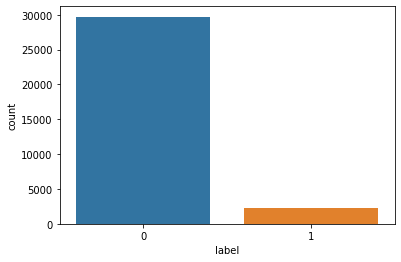

In [8]:
import seaborn as sns
labelGroup_df = train_df.groupby(['label']).count()
labelGroup_df.reset_index(inplace = True)
labelGroup_df = labelGroup_df[['label','id']]
total = labelGroup_df.id.sum()
labelGroup_df['Percentage'] = labelGroup_df.id.apply(lambda count:100*(count/total))

# sns.barplot(x='label',y='Percentage', data = labelGroup_df)
sns.countplot(x='label', data = train_df)
print(labelGroup_df)

Observation:
We have a dataset imbalance here.
Event rate = 7%

We have to re-sample the data to lower the imbalance here.

We can't rely on accuracy alone as a metric for evaluation. Rather F1 score should suffice our need.


In [12]:
import numpy as np
from wordcloud import STOPWORDS
METAFEATURES = []

# word count
train_df['word_count'] = train_df['tweet'].apply(lambda tweet: len(str(tweet).split()))
test_df['word_count'] = test_df['tweet'].apply(lambda tweet: len(str(tweet).split()))
METAFEATURES.append('word_count')

# unique_word_count
train_df['unique_word_count'] = train_df.tweet.apply(lambda tweet: len(set(str(tweet).split())))
test_df['unique_word_count'] = test_df.tweet.apply(lambda tweet: len(set(str(tweet).split())))
METAFEATURES.append('unique_word_count')

# stop_word_count
train_df['stopword_count'] = train_df.tweet.apply(lambda tweet: len([word for word in str(tweet).split() if word in STOPWORDS]))
test_df['stopword_count'] = test_df.tweet.apply(lambda tweet: len([word for word in str(tweet).split() if word in STOPWORDS]))
METAFEATURES.append('stopword_count')

# url_count
train_df['url_count'] = train_df.tweet.apply(lambda tweet: len([word for word in tweet.split() if ('https' in word or 'http' in word)]))
test_df['url_count'] = test_df.tweet.apply(lambda tweet: len([word for word in tweet.split() if ('https' in word or 'http' in word)]))
METAFEATURES.append('url_count')

#mean_word_length
train_df['mean_word_length'] = train_df.tweet.apply(lambda tweet: np.mean([len(word) for word in tweet.split()]))
test_df['mean_word_length'] = test_df.tweet.apply(lambda tweet: np.mean([len(word) for word in tweet.split()]))
METAFEATURES.append('mean_word_length')

# char count
train_df['char_count'] = train_df.tweet.apply(lambda tweet: len(str(tweet)))
test_df['char_count'] = test_df.tweet.apply(lambda tweet: len(str(tweet)))
METAFEATURES.append('char_count')

# hashtag_count
train_df['hashtag_count'] = train_df['tweet'].apply(lambda tweet: len([word for word in str(tweet) if word == '#']))
test_df['hashtag_count'] = test_df['tweet'].apply(lambda tweet: len([word for word in str(tweet) if word == '#']))
METAFEATURES.append('hashtag_count')

# mention_count
train_df['mention_count'] = train_df['tweet'].apply(lambda tweet: len([word for word in str(tweet) if word == '@']))
test_df['mention_count'] = test_df['tweet'].apply(lambda tweet: len([word for word in str(tweet) if word == '@']))
METAFEATURES.append('mention_count')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


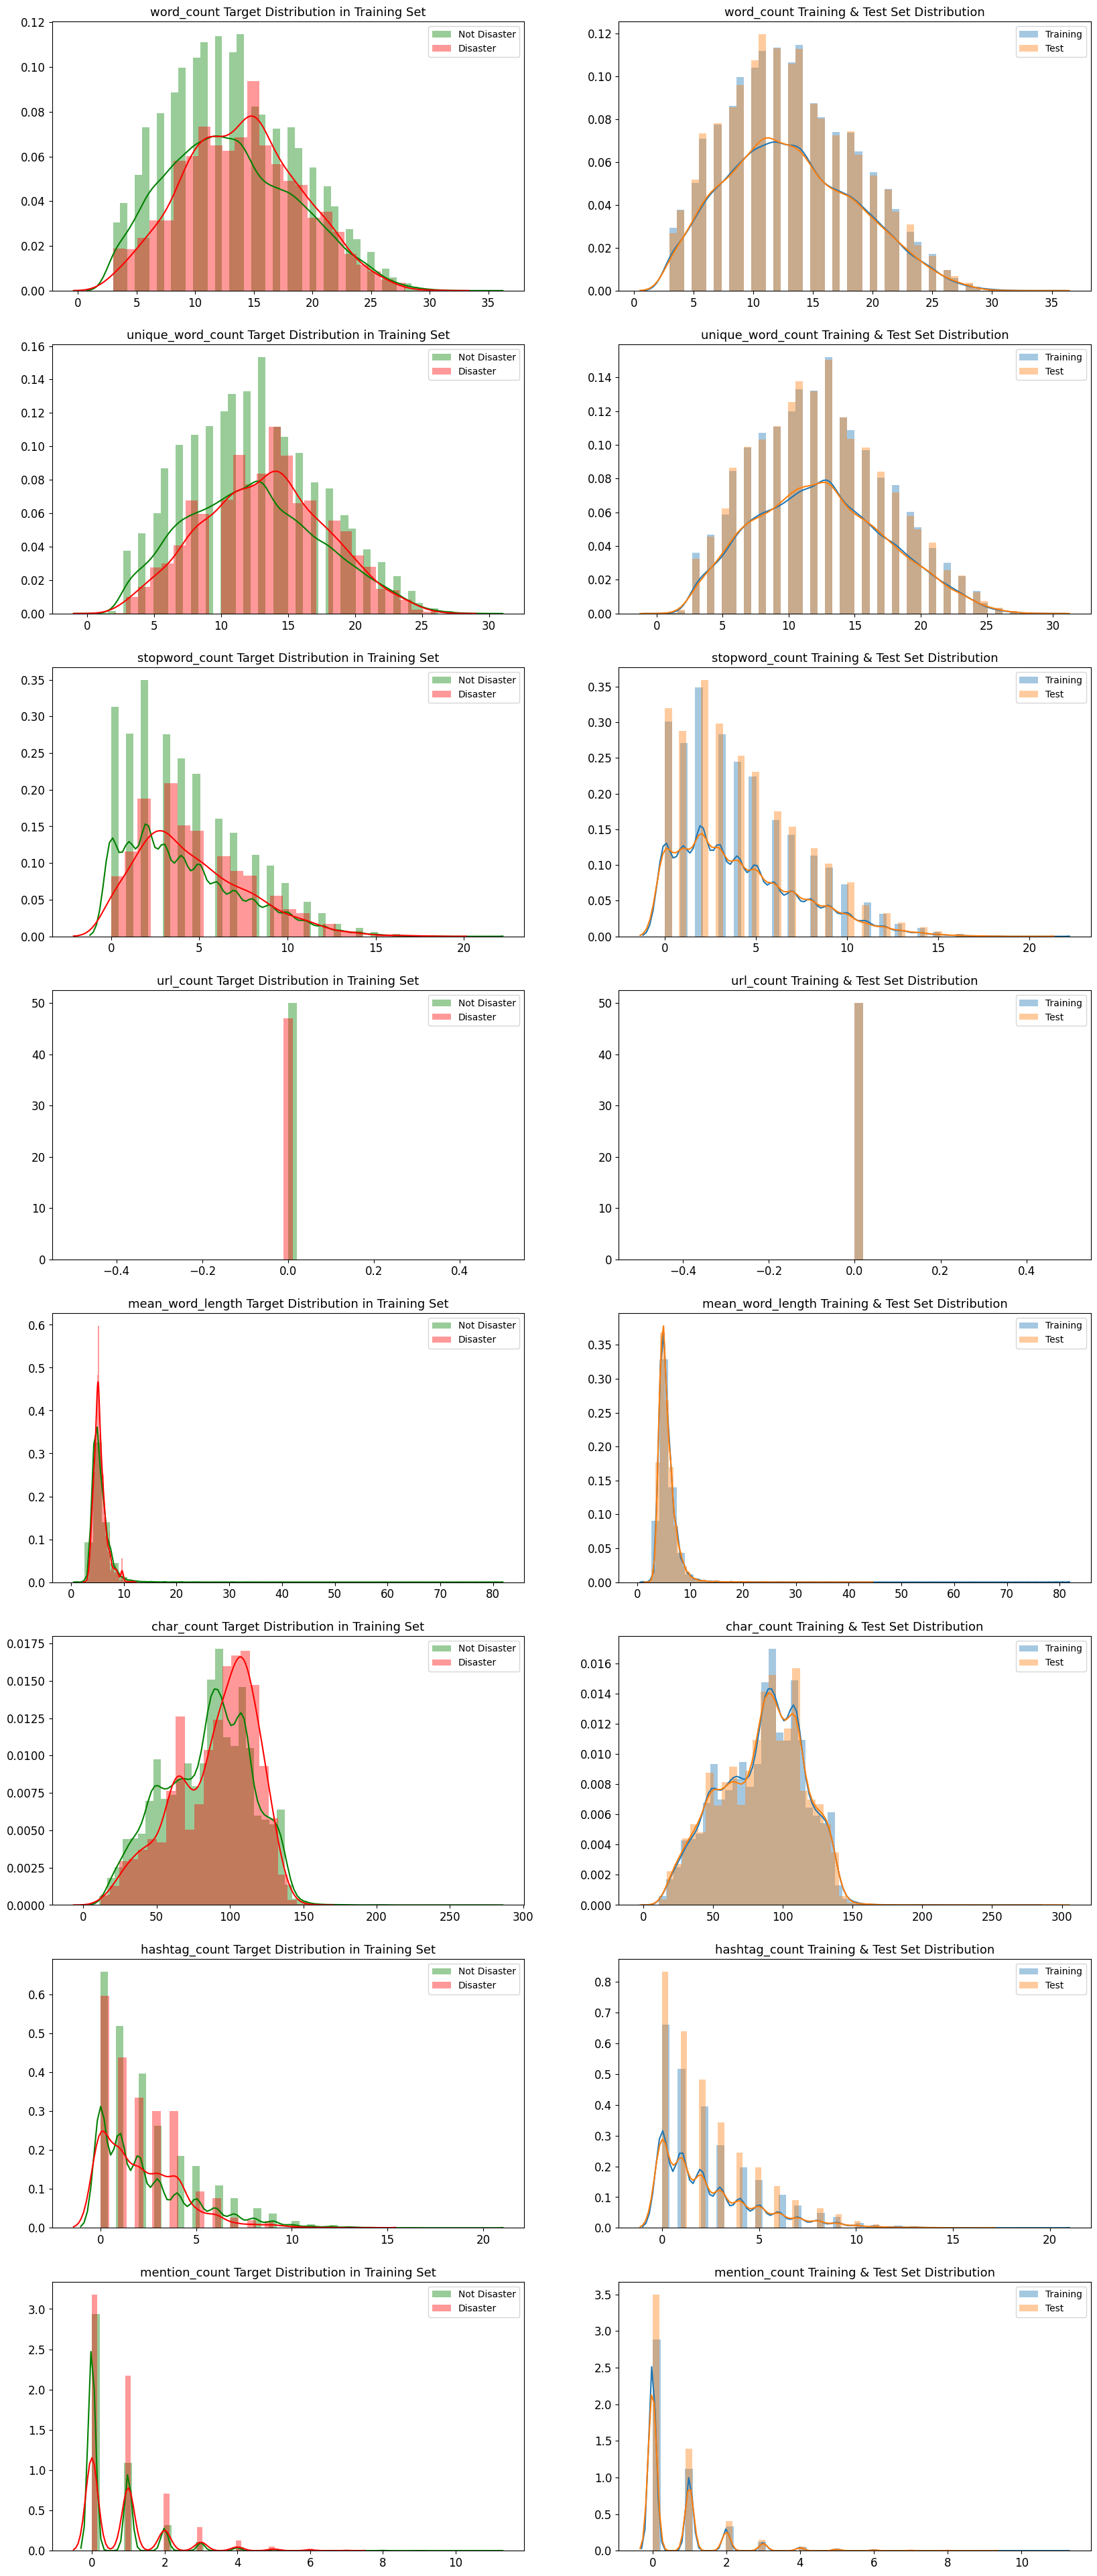

In [13]:
import matplotlib.pyplot as plt
HateSpeechTweets = train_df['label'] == 1

fig, axes = plt.subplots(ncols = 2, nrows = len(METAFEATURES), figsize = (20,50), dpi = 100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(train_df.loc[~HateSpeechTweets][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(train_df.loc[HateSpeechTweets][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(train_df[feature], label='Training', ax=axes[i][1])
    sns.distplot(test_df[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

#### 1.3 Data cleaning
* Get the hashtags
* Remove Urls
* Remove apostrophe
* encode and decode ascii (removes junk characters in the text)
* Remove punctuations
* Remove stopwords
* Keep only English language words
* Apply stemming using Porter Stemmer

In [15]:

train_df['cleaned_text'] = train_df['tweet']
test_df['cleaned_text'] = test_df['tweet']

# get the hashtags
def getHashTags(text):
    tags = ''
    for word in text.split():
        if word.startswith('#'):
            tags += (' ' + word[1:])
            
    return tags.strip()

train_df['hashTags'] = train_df.cleaned_text.apply(lambda row: getHashTags(row))
test_df['hashTags'] = test_df.cleaned_text.apply(lambda row: getHashTags(row))

#remove url
# train_df['cleaned_text'] = train_df.cleaned_text.apply(lambda text : ' '.join([word for word in str(text).split() if not ('http' in word or 'https' in word)]))
train_df['cleaned_text'] = train_df.cleaned_text.apply(lambda text : re.sub(r'http\S+', '', text))
test_df['cleaned_text'] = test_df.cleaned_text.apply(lambda text : re.sub(r'http\S+', '', text))


#remove apostrophes
def removeApostrophes(text):
    aposMap = {
        "'s": ' is',
        "'re" : ' are',
        "'m" : ' am',
        "can't" : 'cannot',
        "ain't" : 'is not',
        "n't" : ' not'
    }
    
    for apos in aposMap:
        if apos in text:
            text = text.replace(apos,aposMap[apos])
    
    return text

train_df['cleaned_text'] = train_df.cleaned_text.apply(lambda text : removeApostrophes(text))
test_df['cleaned_text'] = test_df.cleaned_text.apply(lambda text : removeApostrophes(text))


# encoding decoding
train_df['cleaned_text'] = train_df.cleaned_text.apply(lambda text : text.encode('ascii','ignore').decode('ascii'))
test_df['cleaned_text'] = test_df.cleaned_text.apply(lambda text : text.encode('ascii','ignore').decode('ascii'))


#remove punctuations
def removePunctuations(text):
    modifiedText = re.sub(r'[^\w\s]','',text)
    modifiedText = re.sub(r'[0-9]','',modifiedText)    
    
    return modifiedText

train_df['cleaned_text'] = train_df.cleaned_text.apply(lambda row: removePunctuations(row))
test_df['cleaned_text'] = test_df.cleaned_text.apply(lambda row: removePunctuations(row))


#remove stopwords
stop_words = set(stopwords.words('english')) 
train_df['cleaned_text'] = train_df.cleaned_text.apply(lambda text : ' '.join([word for word in text.split() if not word in stop_words]))
test_df['cleaned_text'] = test_df.cleaned_text.apply(lambda text : ' '.join([word for word in text.split() if not word in stop_words]))

train_df.cleaned_text = train_df.cleaned_text.str.replace('user', '')
test_df.cleaned_text = test_df.cleaned_text.str.replace('user', '')


# # extract only english words
# english_dict = enchant.Dict("en_US")
# train_df['cleaned_text'] = train_df.cleaned_text.apply(lambda text : ' '.join([word for word in text.split() if english_dict.check(word)]))


# stemming / lemmatizer
# I choose lemmatizing over here.
# lemmatizer = WordNetLemmatizer() 
# stemmer = PorterStemmer()
# train_df['cleaned_text'] = train_df.cleaned_text.apply(lambda text : ' '.join([stemmer.stem(word) for word in text.split()]))
# test_df['cleaned_text'] = test_df.cleaned_text.apply(lambda text : ' '.join([stemmer.stem(word) for word in text.split()]))

#### 1.4 Embeddings

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bikramdutta","key":"8f546a4e573fe975ff157b47f560be1c"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

In [ ]:
!kaggle datasets download -d authman/pickled-glove840b300d-for-10sec-loading --force
!kaggle datasets download -d authman/pickled-crawl300d2m-for-kernel-competitions

In [ ]:
# !unzip pickled-crawl300d2m-for-kernel-competitions.zip
!unzip pickled-glove840b300d-for-10sec-loading.zip

In [ ]:
%pwd

'/content/drive/My Drive/Workspaces/twitter_sentiment_analysis'

In [ ]:
import numpy as np
import gc
import re
import string
import operator


In [16]:
%%time

glove_embeddings = np.load('glove.840B.300d.pkl', allow_pickle=True)
fasttext_embeddings = np.load('crawl-300d-2M.pkl', allow_pickle=True)

CPU times: user 15 s, sys: 10.2 s, total: 25.2 s
Wall time: 1min 28s


In [19]:
def build_vocab(X):
    
    tweets = X.apply(lambda s: s.split()).values      
    vocab = {}
    
    for tweet in tweets:
        for word in tweet:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1                
    return vocab


def check_embeddings_coverage(X, embeddings):
    
    vocab = build_vocab(X)    
    
    covered = {}
    oov = {}    
    n_covered = 0
    n_oov = 0
    
    for word in vocab:
        try:
            covered[word] = embeddings[word]
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word]
            n_oov += vocab[word]
            
    vocab_coverage = len(covered) / len(vocab)
    text_coverage = (n_covered / (n_covered + n_oov))
    
    sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return sorted_oov, vocab_coverage, text_coverage



In [21]:
train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(train_df['tweet'], glove_embeddings)
test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(test_df['tweet'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_glove_vocab_coverage, test_glove_text_coverage))

train_fasttext_oov, train_fasttext_vocab_coverage, train_fasttext_text_coverage = check_embeddings_coverage(train_df['tweet'], fasttext_embeddings)
test_fasttext_oov, test_fasttext_vocab_coverage, test_fasttext_text_coverage = check_embeddings_coverage(test_df['tweet'], fasttext_embeddings)
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_fasttext_vocab_coverage, train_fasttext_text_coverage))
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_fasttext_vocab_coverage, test_fasttext_text_coverage))

GloVe Embeddings cover 32.37% of vocabulary and 79.64% of text in Training Set
GloVe Embeddings cover 36.91% of vocabulary and 79.44% of text in Test Set
FastText Embeddings cover 29.82% of vocabulary and 67.55% of text in Training Set
FastText Embeddings cover 33.16% of vocabulary and 67.32% of text in Test Set


In [22]:
train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(train_df['cleaned_text'], glove_embeddings)
test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(test_df['cleaned_text'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_glove_vocab_coverage, test_glove_text_coverage))

train_fasttext_oov, train_fasttext_vocab_coverage, train_fasttext_text_coverage = check_embeddings_coverage(train_df['cleaned_text'], fasttext_embeddings)
test_fasttext_oov, test_fasttext_vocab_coverage, test_fasttext_text_coverage = check_embeddings_coverage(test_df['cleaned_text'], fasttext_embeddings)
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_fasttext_vocab_coverage, train_fasttext_text_coverage))
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_fasttext_vocab_coverage, test_fasttext_text_coverage))

GloVe Embeddings cover 58.19% of vocabulary and 89.55% of text in Training Set
GloVe Embeddings cover 63.39% of vocabulary and 89.31% of text in Test Set
FastText Embeddings cover 57.97% of vocabulary and 89.22% of text in Training Set
FastText Embeddings cover 63.31% of vocabulary and 88.95% of text in Test Set


We need to delete the files later.


Check for ambiguous tweets

In [23]:
ambiguous_set = train_df.groupby(['tweet']).nunique().sort_values(by = 'label', ascending = False)
mislabeled_df = ambiguous_set[ambiguous_set.label > 1]['label']
mislabeled_df

Series([], Name: label, dtype: int64)

Save the preprocessed Dataframes

In [49]:
import csv

train_df.to_csv('data/preprocessed_train.csv')
test_df.to_csv('data/preprocessed_test.csv')

In [51]:
train_df_test1 = pd.read_csv('data/preprocessed_train.csv')

print(train_df.cleaned_text.isna().any())

False
